# Agent-based Transportation Model

In [ ]:
import logging
from itertools import combinations
import ssl; ssl._create_default_https_context = ssl._create_stdlib_context

from pyrosm.data import sources
import ipywidgets as widgets
from IPython.display import display
from shapely.geometry import Point, LineString

from dpd.mapping import Map, Intersection, Road
from dpd.modeling import (
    Driver,
    TransportationModel,
    OriginDestinationDataFrame,
    Zones,
    ABTMMap,
)
from dpd.osm import OSMMap
from dpd.osrm import OSRM

logging.basicConfig(level=logging.INFO)

In [ ]:
region = widgets.Select(
    options=list(
        map(
            lambda x: x.replace("_", " ").title().replace("Of", "of"),
            sources.available["subregions"]["usa"],
        )
    ),
    description="Region",
    rows=10,
)
display(region)

Select(description='Region', options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'Colorado', 'Connecticut', '…

In [3]:
def test_map():
    map_ = Map()
    for x in range(2):
        for y in range(2):
            map_.add_intersection(Intersection(str([x, y]), Point(x, y)))
    for input_intersection, output_intersection in combinations(
        map_.intersections["Intersection"], 2
    ):
        name = input_intersection.name + " to " + output_intersection.name
        geometry = LineString(
            [input_intersection.geometry, output_intersection.geometry]
        )
        map_.add_road(Road(name, geometry, input_intersection, output_intersection, 1))
    return  map_


map_ = test_map()
#map_.plot(include_intersections=True)

In [4]:
osmmap = OSMMap(region.value)
osmmap.transform_roads_to_aea()

 20%|█▉        | 6584/33134 [00:00<00:00, 65833.47it/s]

Building intersections...


  0%|          | 0/26548 [00:00<?, ?it/s]

Building roads...


 16%|█▌        | 4171/26548 [00:10<00:23, 969.71it/s]

two-way street with only one lane: 3952


 21%|██        | 5634/26548 [00:13<00:44, 470.92it/s] 

two-way street with only one lane: 5558


 37%|███▋      | 9788/26548 [00:20<00:24, 695.97it/s]

two-way street with only one lane: 9668


 41%|████      | 10922/26548 [00:22<00:25, 624.33it/s]

two-way street with only one lane: 10816


 44%|████▍     | 11773/26548 [00:23<00:19, 767.81it/s]

two-way street with only one lane: 11622


 58%|█████▊    | 15274/26548 [00:27<00:13, 809.35it/s] 

two-way street with only one lane: 15116


 59%|█████▊    | 15595/26548 [00:28<00:14, 759.76it/s]

two-way street with only one lane: 15478
two-way street with only one lane: 15623
two-way street with only one lane: 15624


 88%|████████▊ | 23476/26548 [00:37<00:03, 861.41it/s] 

two-way street with only one lane: 23387
two-way street with only one lane: 23388
two-way street with only one lane: 23389
two-way street with only one lane: 23390


 96%|█████████▋| 25618/26548 [00:39<00:00, 1046.82it/s]

two-way street with only one lane: 25399


100%|██████████| 26548/26548 [00:40<00:00, 656.56it/s] 


Generated 33134 intersections and 94174 roads.


In [2]:
class StopIntersection(Intersection):
    """
    🛑 Two-way and four-way stop intersections are the same. The only difference is if some lanes have priority over the stop sign (lanes_with_priority).
    """
    def __init__(self, model, name, geometry):
        super(StopIntersection, self).__init__(model, name, geometry)
        self.lanes_with_priority = [] 
        self.intersection_clear = True

    def add_input_lane(self, input_lane, priority=False):
        self.input_lanes.append(input_lane)
        if priority:
            self.lanes_with_priority.append(input_lane)

    def step(self):
        self.intersection_clear = True

    def new_approach(self, approacher):
        if approacher.lane in self.lanes_with_priority:
            #print(approacher.name, "We have priority. We are going.")
            approacher.proceed_through_intersection()
            self.intersection_clear = False
        elif self.intersection_clear:
            #print(approacher.name, "Intersection clear. We are going.")
            approacher.proceed_through_intersection()
            self.intersection_clear = False
        else:
            #print(approacher.name, "🛑")
            approacher.stop()


class SignalIntersection(YieldIntersection):
    """
    🚦🚥 We have a signal plan that updates lanes_with_green after time. Traffic follows the signal plan.
    """

    def __init__(self, intersection, model):
        super().__init__(self, intersection, model)
        self.create_signal_plan()
        self.phase = 0
        self.time_in_phase = 0
        
    def create_signal_plan(self):
        signal_plan = []
        for road in self.input_roads:
            phase = {"time": 5, "lanes_with_green": []}
            for lane in road.lanes:
                phase["lanes_with_green"].append(lane)
        self.signal_plan = signal_plan
        self.lanes_with_green = signal_plan[0]["lanes_with_green"]

    def step(self):
        if self.time_in_phase < self.signal_plan[self.phase]["time"]:
            self.time_in_phase += 1
        else:
            if self.phase < len(self.signal_plan) - 1:
                self.phase += 1
            else:
                self.phase = 0
            self.time_in_phase = 0
            self.lanes_with_green = self.signal_plan[self.phase]["lanes_with_green"]

    def new_approach(self, approacher):
        if approacher.lane in self.lanes_with_green:
            approacher.proceed_through_intersection()
        else:
            approacher.stop()

NameError: name 'Intersection' is not defined

In [1]:
# Issues
# 1. Turns yield to oncoming traffic - compute the angles of lanes that approach intersections. if they are within say 15 degrees, no turn, if not, we need to add a yeild to the intersection logic.
#    a. we could get turns from osrm... then the route contains them and we know before we approach the intersection?
# 2. Map generation
#    b. Driveways - just need a way to generate these from routes - where do people start and stop.
#    d. get priority lanes from osm for stop signs
#    e. higher quality signal plan generation
#    f. https://wiki.openstreetmap.org/wiki/Tag:highway%3Dstop
# 3. Better visualization
#    a. lanes w/ width
# 4. Tests - probably at least one for each class and method
# 5. Better physics - e.g. acceleration, deceleration
# 6. Plot a time series in Folium from websocket data?

7b3e5e2f-a108-4591-8672-7c005c7789b3 POINT (0 0)
87cb0083-835a-41bb-96dc-a69751db8563 POINT (0 1)
7b3e5e2f-a108-4591-8672-7c005c7789b3 POINT (0 0.3)
87cb0083-835a-41bb-96dc-a69751db8563 POINT (0.2121320343559642 0.7878679656440357)
87cb0083-835a-41bb-96dc-a69751db8563 POINT (0.4242640687119285 0.5757359312880715)
7b3e5e2f-a108-4591-8672-7c005c7789b3 POINT (0 0.6)
87cb0083-835a-41bb-96dc-a69751db8563 POINT (0.6363961030678926 0.3636038969321074)
7b3e5e2f-a108-4591-8672-7c005c7789b3 POINT (0 0.8999999999999999)
7b3e5e2f-a108-4591-8672-7c005c7789b3 POINT (0 1)
7b3e5e2f-a108-4591-8672-7c005c7789b3 reached end of lane, pass control to intersection
87cb0083-835a-41bb-96dc-a69751db8563 POINT (0.8485281374238569 0.1514718625761431)
7b3e5e2f-a108-4591-8672-7c005c7789b3 POINT (0 1)
87cb0083-835a-41bb-96dc-a69751db8563 POINT (1 0)
87cb0083-835a-41bb-96dc-a69751db8563 reached end of lane, pass control to intersection
7b3e5e2f-a108-4591-8672-7c005c7789b3 POINT (0.3 1)
87cb0083-835a-41bb-96dc-a69751

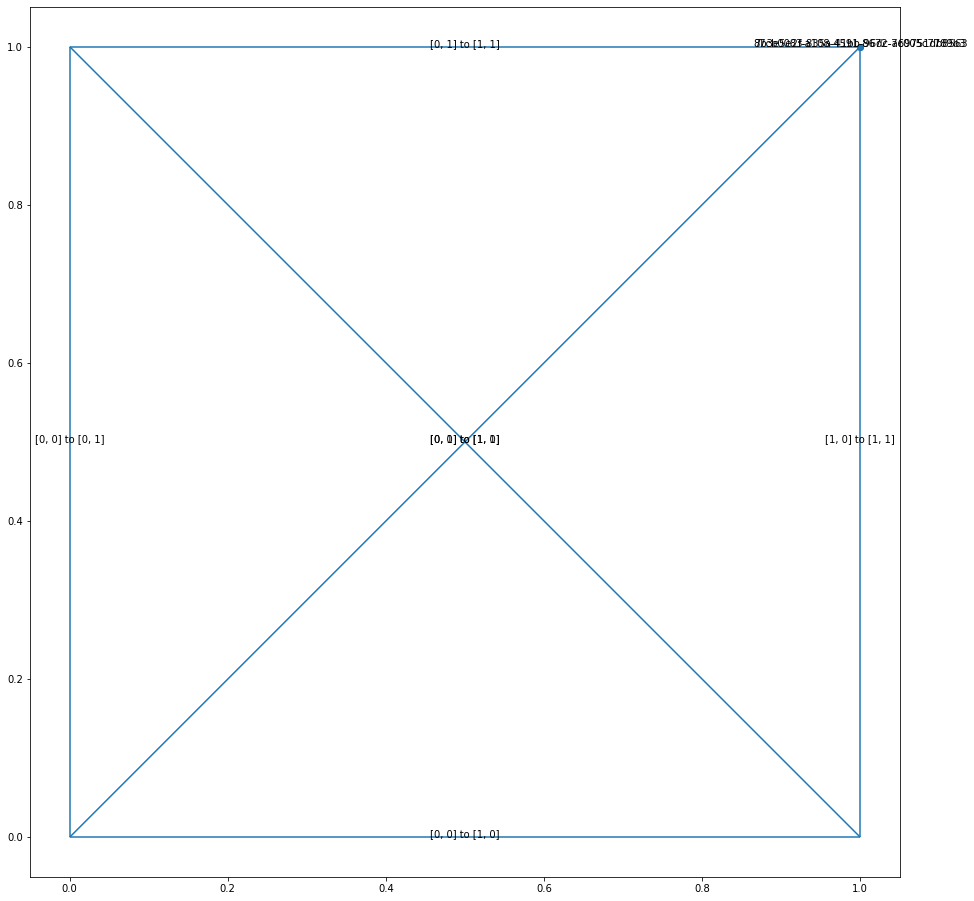

In [13]:
model = TransportationModel()
abtmmap = ABTMMap(model, map_)

p1 = Driver(model, Point(0,0), [
    abtmmap.roads.loc["[0, 1] to [1, 1]"]["Road"],
    abtmmap.roads.loc["[0, 0] to [0, 1]"]["Road"]
])
p2 = Driver(model, Point(0,1), [
    abtmmap.roads.loc["[1, 0] to [1, 1]"]["Road"],
    abtmmap.roads.loc["[0, 1] to [1, 0]"]["Road"]
])
for person in [p1, p2]:
    abtmmap.add_person(person)

for x in range(12):
    model.step()
    
abtmmap.abtmplot(include_roads=True)

This is what was done in peopleModel.py

In [14]:
import us
YEAR = "2017"

zones = Zones.from_uscensus(str(us.states.lookup(region.value).fips), YEAR)
od = OriginDestinationDataFrame(
    OriginDestinationDataFrame.from_lodes(
        us.states.lookup(region.value).abbr.lower(), YEAR
    ).sample(100)
)

This is what was done in routeModel.py

In [16]:
osrm = OSRM(
    region="north-america/us/"
    + us.states.lookup(region.value).name.lower().replace(" ", "-"),
    profile_directory="/usr/local/Cellar/osrm-backend/5.24.0/share/osrm/profiles/",
    profile="car",
)
p = osrm.routed()
from time import sleep

sleep(1)
od.add_geometry_from_zones(zones)
od.add_route_hw_from_osrm(url_base="http://localhost:5000", mode="driving")
p.kill()

NameError: name 'OSRM' is not defined

This is what was done in simulation.py

In [ ]:
model = TransportationModel()
abtmosmmap = ABTMMap(model, osmmap)


def nodes_to_roads(map_, nodes_in):
    nodes = []
    for node in nodes_in:
        if node in map_.intersections.index:
            nodes.append(node)
    roads = []
    # print(nodes)
    for i in range(len(nodes) - 1):
        # print("Finding lane from node", nodes[i], "to node", nodes[i+1])
        for road in map_.intersections.loc[nodes[i]]["Intersection"].output_roads:
            # if road.output_intersection:
            #    print(road.output_intersection.name)
            if (
                road.output_intersection
                and road.output_intersection.name == nodes[i + 1]
            ):
                roads.append(road)
                # print("Found lane:", road.name, "that goes from", road.input_intersection.name, "and goes to", road.output_intersection.name)
                break
    return roads


for _, person in tqdm(od.head(3).iterrows(), total=len(od)):
    route = nodes_to_roads(
        abtmosmmap, person.routes[0]["legs"][0]["annotation"]["nodes"]
    )
    person = Driver(model, person.home_geometry, route)
    abtmosmmap.add_person(person)

abtmosmmap.transform_intersections_to_aea()
abtmosmmap.transform_roads_to_aea()
abtmosmmap.transform_people_to_aea()

In [9]:
abtmosmmap.abtmplot_folium()

In [10]:
for x in range(100):
    for x in range(100):
        model.step()
    abtmosmmap.post_people()

581e76ad-4b66-4695-a7cb-0e734128915e POINT (-77.01044272680274 38.92572060165859)
b12b46cf-847d-43f2-a882-ff88d337cd2d POINT (-77.01567572825775 38.82569734173583)
b12b46cf-847d-43f2-a882-ff88d337cd2d reached end of lane, pass control to intersection
3689a4fa-0f38-4613-b4eb-e340f8ca7db0 POINT (-77.04449263617128 38.92712205152373)
b12b46cf-847d-43f2-a882-ff88d337cd2d POINT (-76.972346 38.849997)
581e76ad-4b66-4695-a7cb-0e734128915e POINT (-76.99264429999999 38.883109)
581e76ad-4b66-4695-a7cb-0e734128915e reached end of lane, pass control to intersection
3689a4fa-0f38-4613-b4eb-e340f8ca7db0 POINT (-76.9810009 38.9089109)
3689a4fa-0f38-4613-b4eb-e340f8ca7db0 reached end of lane, pass control to intersection
3689a4fa-0f38-4613-b4eb-e340f8ca7db0 POINT (-76.9810009 38.9089109)
581e76ad-4b66-4695-a7cb-0e734128915e POINT (-76.9943529 38.883809)
b12b46cf-847d-43f2-a882-ff88d337cd2d POINT (-76.971052 38.848844)
b12b46cf-847d-43f2-a882-ff88d337cd2d reached end of lane, pass control to intersecti

This is what was done in view.py

In [11]:
abtmosmmap.abtmplot_folium()

<AxesSubplot:>

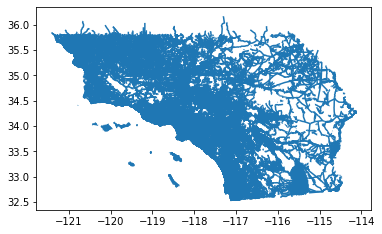

In [118]:
cycling_net = osm.get_network("cycling")
cycling_net.plot()

In [22]:
drive_net.columns

Index(['access', 'area', 'bicycle', 'bicycle_road', 'bridge', 'busway',
       'cycleway', 'est_width', 'foot', 'footway', 'highway', 'junction',
       'lanes', 'lit', 'maxspeed', 'motorcar', 'motorroad', 'motor_vehicle',
       'name', 'oneway', 'overtaking', 'path', 'passing_places', 'psv', 'ref',
       'service', 'segregated', 'sidewalk', 'smoothness', 'surface',
       'tracktype', 'tunnel', 'turn', 'width', 'id', 'timestamp', 'version',
       'tags', 'geometry', 'osm_type'],
      dtype='object')

In [109]:
drive_net["cycleway"].value_counts()

lane             30470
shared_lane       2393
no                 780
track              313
shared              76
buffered_lane       34
separate            32
lane;track          17
yes                 16
opposite_lane        9
proposed             5
on_roadway           4
route                3
cyclestreet          2
designated           2
none                 2
shoulder             2
crossing             2
Anywhere             1
Anywhere Safe        1
Name: cycleway, dtype: int64

In [110]:
import folium

output = drive_net[drive_net["cycleway"] == "track"]

points = folium.features.GeoJson(output)

m = folium.Map(zoom_start=9)
m.add_children(points)

<ipython-input-110-55a97ba60500>:8: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  m.add_children(points)


In [81]:
drive_net["maxspeed_a"].value_counts()

35.0     15055
45.0     14566
40.0     13866
65.0     10565
25.0     10469
50.0      6184
55.0      5072
30.0      4732
15.0      3258
70.0      1729
5.0        986
10.0       818
14.0       615
60.0       500
20.0       407
8.0        146
64.0       121
48.0        62
18.0        40
16.0        26
7.0         18
3.0         17
56.0        16
72.0        14
75.0        13
13.0        12
17.0         6
19.0         4
4.0          4
80.0         2
12.0         2
54.0         1
69.0         1
47.0         1
11.0         1
42.0         1
37.0         1
24.0         1
540.0        1
Name: maxspeed_a, dtype: int64

In [337]:
q = GeoDataFrame([Point(-77, 38.9).buffer(.01)], columns=["geometry"])
q.crs = "EPSG:4326"
folium_map = folium.Map(location=(38.9, -77), zoom_start=12)


l = gpd.GeoDataFrame(zip(
    map(lambda x: x.lanes[0].geometry, m.roads.values()),
    map(lambda x: x.name, m.roads.values()),
    map(lambda x: len(x.lanes), m.roads.values()),

), columns = ["geometry", "name", "number_of_lanes"])
l.crs = "EPSG:4326"

n = gpd.overlay(l, q, how='intersection')
n


points = folium.GeoJson(
    n,
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name', "number_of_lanes"],
        )
)

points.add_to(folium_map)


folium_map

In [274]:
import folium

from geopandas import GeoDataFrame

folium_map = folium.Map(location=(38.9, -77), zoom_start=12)

p = gpd.GeoDataFrame(zip(
    map(lambda x: x.geometry, people),
    map(lambda x: str(x.unique_id), people),
    map(lambda x: str(list(map(lambda y: y.name, x.route))[0:10]).replace("[","").replace("]","").replace(",","<br>"), people),
), columns = ["geometry", "unique_id", "route (next 10)"])
p.crs = "EPSG:4326"

points = folium.GeoJson(
    p,
    tooltip=folium.features.GeoJsonTooltip(
        fields=['unique_id', "route (next 10)"],
        )
)
points.add_to(folium_map)


#l = gpd.GeoDataFrame(zip(
#    map(lambda x: x.geometry, m.lanes.values()),
#    map(lambda x: x.name, m.lanes.values()),
#), columns = ["geometry", "name"])
#l.crs = "EPSG:4326"


#points = folium.features.GeoJson(l)
#points.add_to(folium_map)


folium_map
